# Homework 1

For this homework assignment, we're going to look at neural spikes recorded from the mouse olfactory bulb. These experiments were done with the goal of understanding how our sense of smell works. See these [eLife](https://elifesciences.org/articles/22630) and [Science](https://www.science.org/doi/full/10.1126/science.aat6904) papers for more information on the big picture. The data were downloaded from an [archive on CRCNS.org](https://crcns.org/data-sets/pcx/pcx-1/about-pcx-1).

In the data you will look at, electrodes recorded neural activity as mice were exposed to the odors represented by a library of chemicals. An olfactometer is an instrument which allows an evaporated chemical to be puffed by an animal's nose (and then takes care of subsequently cleaning the air by sucking the odor out and replacing it with chemical free air during inter-trial intervals). So individual trials are marked by timestamps when the olfactometer valve was opened, releasing the odor. In addition, what brings smells to the sensory epithelium in the nasal cavities is a combination of passive diffusion and, much more importantly, inhalation. The inhatlation cycle was also measured in these experiments, and the timesteps of inhalation onset are also given. The experiments comprised ~10 repeated trials for each of 16 different odors. Finally, we have spikes from 68 individual neurons. 

Let's start by loading the data. The neural activity and behavioral timestamps are stored in numpy arrays in `150313_spikes_valvetimes_prex.npz`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# If you are running in a Google collab notebook, this should grab the data for you.


!wget https://github.com/ckemere/elec380/raw/refs/heads/main/HW2/150313_spikes_valvetimes_prex.npz

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
npzfile = np.load('150313_spikes_valvetimes_prex.npz', allow_pickle=True)

# npzfile.files will print out contents!
spike_times = npzfile['spike_times'] # 68-neuron dimensional array, each array entry is vector of timestamps for each spike from that neuron
# The olfactometer is coded for 16 different odors (actually some are the same chemical at different concentrations)
odor_valve_times = npzfile['odor_valve_times'] # 16-odor dimensional array, each entry is a vector of ~10 timestamps of repeated trials when that odor was released
inhalation_times = npzfile['prex'] # All detected inhalation timestamps for the whole experiment
odor_inhalation_times = npzfile['odor_prex_times'] # 16-odor x ~10 repititons - timestamps of the first inhalation following odor release for a given trial

The first question you will answer from this data is the following: Is the neural activity of individual neurons across trials for an odor temporally aligned to the time the odor is released or the time of inhalation? 

To answer this question, you will need to be able to visualize the activity of the neurons across trials. There are two ways to do this. First, we can create a "raster plot". A "raster plot" plots the spike times of an individual neuron across trials aligned to tiral timestamps. Let us create a function that will plot small vertical lines at a specific y-axis height.

In [4]:
def plot_ticks(t, y_base, ax=None, height=0.8, **kwargs):
  """
  plot_ticks plots vertical lines (tick marks) at multiple x-axis locations.

  :t vector of x-axis times for a tick mark
  :y_base each tick mark starts at this y-axis location
  :height each tick mark starts at y_base and is height tall (default 0.8)
  :ax use this pyplot figure axes to plot into (if None, use the current axes)
  """
  if not ax: # cover the situation where no axes are specified
    ax = plt.gca()
  ax.vlines(t, y_base, y_base+height, **kwargs)


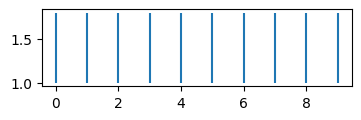

In [5]:
# Try out our function
fig, ax = plt.subplots(1,1, figsize=(4,1))
plot_ticks(np.arange(10), 1)

Now that we can plot rasters, we need to extract the snippets of data that correspond to each trial. Let's begin by defining trials by the time the odor is released (`odor_valve_times`). In order to plot rasters, we can loop over the repeated trials. We'll define the spikes associated with a trial as the ones which occur **between 0.5 s before our timestamp and 1.0 s after**. (This is an arbitrarily chosen window size that suffices for this homework assignment!)

Though it's somewhat inefficient, let's begin by defining a function that takes the spike times of a neuron for the whole experiment, and the timestamp of a trial, and return only the spikes in our chosen window.

In [6]:
def find_nearby_spikes(ts, t0, window=(-0.5, 1)):
  return ts[(ts > t0 + window[0]) & (ts <= t0 + window[1])] - t0

Now let's use our two functions to plot the spike rasters for one of the neurons corresponding to the trials for one of the odors.

Text(0, 0.5, 'Trial')

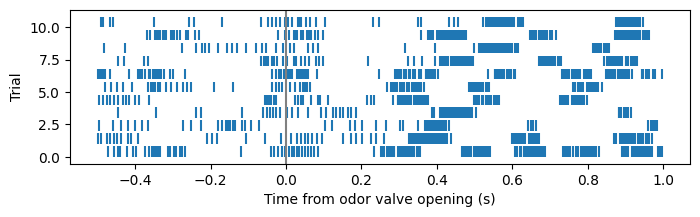

In [7]:
odor = 12
neuron = 24

fig, ax = plt.subplots(1, 1, figsize=(8,2))
for trial, ovt in enumerate(odor_valve_times[odor]): # "enumerate" takes a list and returns (index, item) for each item in the list
  relative_spikes = find_nearby_spikes(spike_times[neuron], ovt)
  plot_ticks(relative_spikes, trial, ax=ax) # we'll use the trial number as our y-location, so the first trial is at the bottom

ax.axvline(0, color='gray')
ax.set_xlabel('Time from odor valve opening (s)')
ax.set_ylabel('Trial')


Let's make a peristimulus time histogram of these data. A PSTH shows the average number of events (spikes in this case) in a time bin averaged across time-aligned trials. While we could roll our own histogram function, both the numpy and scipy packages give us helper functions for this task. Let's use numpy's `histogram` (documentation [here](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html)). The way we'll use it, the `np.histogram` function counts the number of items in each bin of time. The naive way of using it would be to run `np.histogram()` on each trial, and then accumulate the counts across trials in a loop. The easier thing to do is to let the function do this work for us. In order to do that, we need to feed it a long vector that contains all of the trials stacked end-to-end. So let's modify our loop to accumulate the data from the trials.

Text(0, 0.5, 'Spikes per bin')

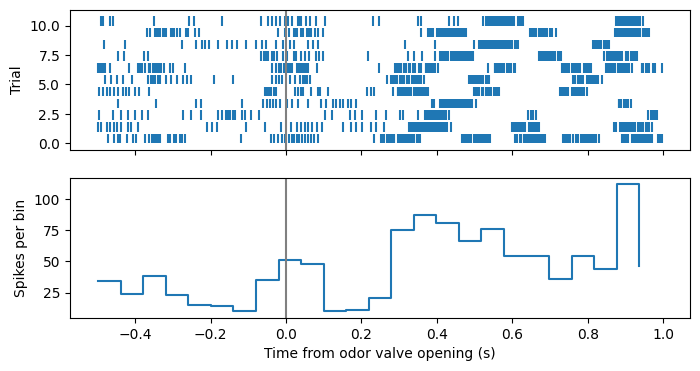

In [ ]:
odor = 12
neuron = 24

fig, ax = plt.subplots(2,1, figsize=(8,4), sharex=True) # note that now ax is a vector of size 2

all_relative_spikes = [] # we'll use this to accumuluate

for trial, ovt in enumerate(odor_valve_times[odor]): # "enumerate" takes a list and returns (index, item) for each item in the list
  relative_spikes = find_nearby_spikes(spike_times[neuron], ovt)
  all_relative_spikes.append(relative_spikes)
  plot_ticks(relative_spikes, trial, ax=ax[0]) # we'll use the trial number as our y-location, so the first trial is at the bottom
ax[0].axvline(0, color='gray')
ax[0].set_ylabel('Trial')

all_relative_spikes = np.hstack(all_relative_spikes) # convert a list of numpy arrays by stacking them end to end
hist, edges = np.histogram(all_relative_spikes,25) # calculate a histogram of our spiking data
ax[1].step(edges[:-1], hist, where='post') # plot it on the second axis, using the left end of the bin as the edges of steps. use where='post' to make values apply until right bin edge.
ax[1].axvline(0, color='gray')


ax[1].set_xlabel('Time from odor valve opening (s)')
ax[1].set_ylabel('Spikes per bin')

While there seems to be a small increase in spikes around the time that the valve opens, we can observe two things. First, it's a bit odd that it increases _before_ the valve opens. Maybe the mouse somehow can anticipate the smell being delivered, but this shouldn't reflect odor coding if it is just anticipation. Second, if we look at the spike rasters, we can see a big increase in firing happens about 200-300 ms after the valve opens, but not in a way that is synchronized to the valve. Could this be related to sniffing? Let's add ticks corresponding to sniffs to see.

Text(0, 0.5, 'Spikes per bin')

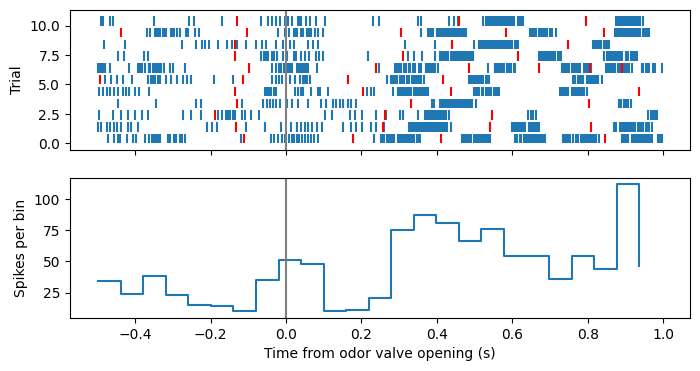

In [9]:
odor = 12
neuron = 24

fig, ax = plt.subplots(2,1, figsize=(8,4), sharex=True) # note that now ax is a vector of size 2

all_relative_spikes = [] # we'll use this to accumuluate

for trial, ovt in enumerate(odor_valve_times[odor]): # "enumerate" takes a list and returns (index, item) for each item in the list
  relative_spikes = find_nearby_spikes(spike_times[neuron], ovt)
  all_relative_spikes.append(relative_spikes)
  plot_ticks(relative_spikes, trial, ax=ax[0]) # we'll use the trial number as our y-location, so the first trial is at the bottom

  relative_breaths = find_nearby_spikes(inhalation_times, ovt) # find inhalation times that happen within our trial window
  plot_ticks(relative_breaths, trial, ax=ax[0], colors='r')

ax[0].axvline(0, color='gray')
ax[0].set_ylabel('Trial')

all_relative_spikes = np.hstack(all_relative_spikes) # convert a list of numpy arrays by stacking them end to end
hist, edges = np.histogram(all_relative_spikes,25) # calculate a histogram of our spiking data
ax[1].step(edges[:-1], hist, where='post') # plot it on the second axis, using the left end of the bin as the edges of steps
ax[1].axvline(0, color='gray')


ax[1].set_xlabel('Time from odor valve opening (s)')
ax[1].set_ylabel('Spikes per bin')

Cool! The big increase of spikes always happens right after a red tick - that means that is strongly aligned to inhalation. Perhaps we should align our analyses to inhalation rather than valve opening.

## Problem 1.
Modify the example code in the previous cell to generate a spike raster and PSTH aligned to inhalation. Remember that the helper data vector `odor_inhalation_times` gives you the time of that first breath after an odor has been released in the same format as `odor_valve_times`. Looking at the resulting spike rasters and the PSTH, which time marker gives us a more temporally precise measure of neural activity?

In [15]:
# Code for problem 1


## Problem 2

Vary the number of the PSTH bins. Compare how the PSTH looks for larger and small bin sizes. While the `np.histogram()` function takes the number of bins as an argument, it's much more relevant to think in terms of bin **size** (in seconds, keeping in mind that the full window is 1.5 s). What bin size do you think best balances temporal precision with across-trial-averaging if you want to understand this neuron's pattern of response to the odor? What is the maximum bin size for which you think the PSTH characterizes the neuron's response well? What is the minimum bin size? What about for neuron number 29?

_You should respond with both figures and text._

# answers here for Problem 2

## Problem 3

Compare the pattern of responses for neurons 12, 17, 19, 24, 29, and 55, aligned to (a) the valve opening, (b) the first sniff, and (c) the second sniff. Make a multi-panel plot of PSTHs with 3 columns and 6 rows.

Do different neurons have different response latencies (i.e., time until the first odor-related spike)? Order the rows of your plots by your preception of the response response latency from shortest to longest.

How does the neural response change from the first to subsequent sniffs?  

_You should respond with both figures and text._

# answers here for Problem 3

## Problem 4

Now, write some code to plot the rasters and the PSTHs for **2** neurons -- number 24 and number 29 -- in the same sets of figures. You can leverage the `height` parameter in the `plot_ticks()` function to have the spikes from the two neurons vertically adjacent to each other on each trial, like this:
```
plot_ticks(relative_spikes1, trial, height = 0.3, ax=ax[0]) 
plot_ticks(relative_spikes2, trial+0.4, height = 0.3, ax=ax[0]) # neuron 2's spikes for each trial will be right above those of neuron 1 
```

Which neuron has a lower latency to responding to the odor? What do you see when you look at the spike raster's associated with the **second** sniff cycle following the odor? Is the relative latency more reliable for the first sniff cycle or subsequent ones? Is this clear from the PSTH?

_You should respond with both figures and text._

# answers here for Problem 4